# Compare ROH between groups
Load empirical ROH Dataframe, and compare ROH sharing between groups with statistical tests (producing p-Values)
Assumes data is ROH analyzed, and pre-processed (into one dataframe, with region and clst Columns set.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from math import log10, floor
from skbio.stats.distance import permanova
from skbio import DistanceMatrix

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
from scipy.stats import mannwhitneyu

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0082.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Functions for statistical Analysis.
The overall scheme: pandas dataframe, subset, col of interested extracted,
and compared with statistic test. Creates Summary dataframe with Latex output for table.

In [62]:
def test_mwu(df, region1="Iberia", region2="Iberia", clst1="Early Neolithic", clst2="Neolithic", 
             col="sum_roh_4-8", prt=True, alternative='two-sided', col_group="region"):
    """MWann Whitney U-Test. Print and return result and nr Individuals in each group
    df: Dataframe to test on
    prt: Whether to print the results"""
    df1 = df[(df["clst"]==clst1) & (df[col_group]==region1)]
    df2 = df[(df["clst"]==clst2) & (df[col_group]==region2)]
    
    test = mannwhitneyu(df1[col], df2[col], alternative=alternative)
    if prt:
        print(test)
        print(f"Loaded {len(df1)} Samples from clst {clst1} {region1}")
        print(f"Loaded {len(df2)} Samples from clst {clst2} {region2}")
        
    return test, len(df1), len(df2)

def test_mwu_groups(df1, df2, col="sum_roh_4-8",
                    prt=True, alternative='two-sided'):
    """Compare two Dataframes with values in col with mannwhitneyu Test"""
    test = mannwhitneyu(df1[col], df2[col], alternative=alternative)
    mean2 = np.mean(df2[col])
    mean1 = np.mean(df1[col])
    mean_diff =  mean2 - mean1
    
    if prt:
        print(test)
        print(f"Loaded {len(df1)} Samples Set1")
        print(f"Loaded {len(df2)} Samples Set2") 
        print(f"Mean 1: {mean1:.4f}")
        print(f"Mean 2: {mean2:.4f}")
        print(f"Mean difference 2 - 1: {mean_diff:.4f}")
    return test, len(df1), len(df2)

def load_ROH_nolong(path="./Empirical/roh_all_inds_final_v42.csv",
                    cm=20, cutoff=50):
    """Load Dataframe without ROH"""
    df = pd.read_csv(path, sep='\t')
    df["sum_roh_4-8"] = df["sum_roh>4"] - df["sum_roh>8"]
    print(f"Loaded {len(df)} Individuals")
    df = df[df[f"sum_roh>{cm}"]<cutoff]
    print(f"Filtered to {len(df)} Individuals with no long ROH")
    return df

def compare_groups(df1, df2, col="sum_roh_4-8",
                   label1="", label2="", rep_panova=0,
                   alternative="two-sided", sig=2, 
                   pr=False):
    
    df = pd.DataFrame({"Group A":[label1], "Group B":[label2]})
    
    ### Set the summary Stats
    df["Median A"] = np.median(df1[col])
    df["#Zero A"] = np.sum(df1[col]==0) 
    df["# A"]= len(df1)
    df["Median B"] = np.median(df2[col])
    df["#Zero B"] = np.sum(df2[col]==0)
    df["# B"] = len(df2)
    
    ### Set the p-Value
    x, y = df1[col], df2[col]
    test = mannwhitneyu(x, y, alternative=alternative)
    #df["p"] = round_sig(test[1], sig=sig)
    df["p"] = test[1]
    df["p"] = df["p"].apply(lambda x: '{:.1e}'.format(x))
    
    if rep_panova>0:
        test1 = anova_2group(x, y, reps=rep_panova)
        df["p1"] = test1["p-value"]
        df["p1"] = df["p1"].apply(lambda x: '{:.1e}'.format(x))
    
    if pr:
        print_latex(df)
    return df

def round_sig(x, sig=2):
    """Round to Significant digits.
    Return rounded number"""
    return round(x, sig-int(floor(log10(abs(x))))-1)

####################################################################
####################################################################

def prep_distance_matrix(x,y):
    """Prepare a Distance Matrix"""
    z=np.concatenate((x,y))
    d_mat = np.abs(z-z[:,None])
    dm = DistanceMatrix(d_mat)
    return dm

def anova_2group(x, y, reps=999):
    """Calculate Anove for 2Group. Return Statistic object"""
    dm = prep_distance_matrix(x,y)
    grouping = ["A"]*len(x) + ["B"]*len(y)
    pma = permanova(dm, grouping, permutations=reps)
    return pma

####################################################################
####################################################################

def print_latex(df, index=False,  float_format="%.1f", ret=False):
    """Print Latex table from Dataframe"""
    out = df.to_latex(index=index, float_format=float_format)
    print(out)

    if ret:
        return out

# Early HG vrs later HG

In [63]:
df = load_ROH_nolong(path="./Empirical/roh_all_inds_final_v42.csv")
df1 = df[(df["age"]>0) & (df["age"]<100000)]
print(f"Filtered to {len(df1)} Inviduals in age range")
df_hg = df1[(df1["economy"]=="Hunter Gatherer")]

Loaded 3732 Individuals
Filtered to 3497 Individuals with no long ROH
Filtered to 1739 Inviduals in age range


In [64]:
df_hg1 =  df_hg[df_hg["age"]>10e3]
df_hg2 =  df_hg[(df_hg["age"]>8e3) & (df_hg["age"]<10e3)]

In [65]:
%%time
df_add = compare_groups(df_hg1, df_hg2, label1 = "HG > 10k BP",  label2 = "HG  8-10k BP", \
                        pr=True, rep_panova=99999)

\begin{tabular}{llrrrrrrll}
\toprule
     Group A &       Group B &  Median A &  \#Zero A &  \# A &  Median B &  \#Zero B &  \# B &        p &       p1 \\
\midrule
 HG > 10k BP &  HG  8-10k BP &      30.5 &        0 &   22 &      14.1 &        3 &   37 &  1.5e-04 &  2.0e-05 \\
\bottomrule
\end{tabular}

CPU times: user 12.5 s, sys: 433 µs, total: 12.5 s
Wall time: 12.6 s


# EEF vrs HG Table [Paper]

In [66]:
df = load_ROH_nolong(path="./Empirical/roh_all_inds_final_v42.csv")
df1 = df[(df["age"]>0) & (df["age"]<100000)]
print(f"Filtered to {len(df1)} Inviduals in age range")
df_hg = df1[(df1["economy"]=="Hunter Gatherer")]
df_ef = df1[(df1["economy"]=="Agricultural")]
#set(df_hg["region"])

Loaded 3732 Individuals
Filtered to 3497 Individuals with no long ROH
Filtered to 1739 Inviduals in age range


### All HG vrs Agriculturalists

In [67]:
%%time
df_add = compare_groups(df_hg, df_ef, label1 = "All HG",  label2 = "All Farmers", 
                        pr=True, rep_panova=99999)

\begin{tabular}{llrrrrrrll}
\toprule
Group A &      Group B &  Median A &  \#Zero A &  \# A &  Median B &  \#Zero B &  \# B &        p &       p1 \\
\midrule
 All HG &  All Farmers &      17.0 &       16 &  138 &       0.0 &      543 &  921 &  2.3e-47 &  1.0e-05 \\
\bottomrule
\end{tabular}

CPU times: user 33min 52s, sys: 17min 54s, total: 51min 46s
Wall time: 51min 55s


# HG vrs early Agriculturalists

In [68]:
%%time
df = load_ROH_nolong(path="./Empirical/roh_all_inds_final_v42.csv")
df1 = df[(df["age"]>0) & (df["age"]<100000)]
print(f"Filtered to {len(df1)} Inviduals in age range")
df_hg = df1[(df1["economy"]=="Hunter Gatherer")]
df_ef = df1[(df1["economy"]=="Agricultural")]

regions = ['Aegan', 'Balkans', 
           'Britain', 'Central Europe',
           'Iberia', 'Rome', 'Steppe', 
           'Black Sea', 'North Africa',  "Baltic Sea"]

df_efs, df_vec = [], []

for r in regions:
    df1 = df_hg[df_hg["region"]==r]
    df2 = df_ef[df_ef["region"]==r]
    
    # Set age boundary
    age_max = np.max(df2["age"])
    df3 = df2[df2["age"]> (age_max-2000)].reset_index()
    df_efs.append(df3)
    print(f"{r}: Reduced to {len(df3)}/{len(df2)}, Age Max: {age_max}")
    label1 = r + "-HG"
    label2 = r + "-EF"
    df_add = compare_groups(df1, df3, label1 = label1,  label2 = label2, 
                            rep_panova=99999, pr=False)
    df_vec.append(df_add)
    
df_res = pd.concat(df_vec)

Loaded 3732 Individuals
Filtered to 3497 Individuals with no long ROH
Filtered to 1739 Inviduals in age range
Aegan: Reduced to 27/47, Age Max: 8505.0
Balkans: Reduced to 41/101, Age Max: 7836.0
Britain: Reduced to 90/135, Age Max: 5770.0
Central Europe: Reduced to 25/129, Age Max: 7140.0
Iberia: Reduced to 20/128, Age Max: 7348.0
Rome: Reduced to 11/120, Age Max: 7984.0
Steppe: Reduced to 10/10, Age Max: 5456.0
Black Sea: Reduced to 3/3, Age Max: 4754.0
North Africa: Reduced to 1/1, Age Max: 3635.0
Baltic Sea: Reduced to 10/10, Age Max: 1431.0
CPU times: user 1min 44s, sys: 110 ms, total: 1min 44s
Wall time: 1min 44s


In [69]:
print(df_res.to_latex(index=False,  float_format="%.1f"))

\begin{tabular}{llrrrrrrll}
\toprule
           Group A &            Group B &  Median A &  \#Zero A &  \# A &  Median B &  \#Zero B &  \# B &        p &       p1 \\
\midrule
          Aegan-HG &           Aegan-EF &      30.9 &        0 &    1 &       0.0 &       18 &   27 &  6.0e-02 &  3.5e-02 \\
        Balkans-HG &         Balkans-EF &      13.3 &        3 &   37 &       4.2 &       17 &   41 &  5.5e-06 &  1.0e-05 \\
        Britain-HG &         Britain-EF &      39.8 &        0 &    1 &       5.6 &       18 &   90 &  8.9e-02 &  1.1e-02 \\
 Central Europe-HG &  Central Europe-EF &      42.8 &        0 &    1 &       0.0 &       15 &   25 &  7.5e-02 &  3.8e-02 \\
         Iberia-HG &          Iberia-EF &      25.6 &        0 &    4 &       4.7 &        7 &   20 &  1.5e-01 &  9.2e-02 \\
           Rome-HG &            Rome-EF &      65.8 &        0 &    2 &       4.4 &        5 &   11 &  3.3e-02 &  1.2e-02 \\
         Steppe-HG &          Steppe-EF &      39.2 &        2 &   12 &    

### HG vrs Early Farmers 
Needs above function

In [70]:
df1 = pd.concat(df_efs)
df_res = compare_groups(df_hg, df1, label1 = "All HG",  label2 = "Early Farmers (EF)", 
                        rep_panova=99999, pr=True)

\begin{tabular}{llrrrrrrll}
\toprule
Group A &             Group B &  Median A &  \#Zero A &  \# A &  Median B &  \#Zero B &  \# B &        p &       p1 \\
\midrule
 All HG &  Early Farmers (EF) &      17.0 &       16 &  138 &       4.5 &       91 &  238 &  3.1e-22 &  1.0e-05 \\
\bottomrule
\end{tabular}



### Iberia

In [71]:
df = load_ROH_nolong(path="./Empirical/roh_all_inds_final_v42.csv")
df_ef = df[(df["economy"]=="Agricultural")]
df1 = df_ef[df_ef["pop"].str.contains("Iberia_EN")]
df2 = df_ef[df_ef["pop"].str.contains("Iberia_MN")]

Loaded 3732 Individuals
Filtered to 3497 Individuals with no long ROH


In [72]:
df_add = compare_groups(df1, df2, label1 = "Iberia-EN",  label2 = "Iberia-MN", 
                        rep_panova=99999, pr=True)

\begin{tabular}{llrrrrrrll}
\toprule
   Group A &    Group B &  Median A &  \#Zero A &  \# A &  Median B &  \#Zero B &  \# B &        p &       p1 \\
\midrule
 Iberia-EN &  Iberia-MN &      32.8 &        0 &    7 &       0.0 &        9 &   15 &  1.5e-04 &  1.0e-05 \\
\bottomrule
\end{tabular}



### Aceramic to Anatolia-N

In [73]:
df = load_ROH_nolong(path="./Empirical/roh_all_inds_final_v42.csv")

df_ac = df[(df["economy"]=="Aceramic Farmer")]
df1 = df_ac[df_ac["pop"].str.contains("Anatolia")]

df_ef = df[(df["economy"]=="Agricultural")]
df2 = df_ef[df_ef["pop"].str.contains("Anatolia_N")]

Loaded 3732 Individuals
Filtered to 3497 Individuals with no long ROH


In [74]:
df_add = compare_groups(df1, df2, label1 = "Anatolia-AC",  label2 = "Anatolia-N", 
                        pr=True, rep_panova=99999)

\begin{tabular}{llrrrrrrll}
\toprule
     Group A &     Group B &  Median A &  \#Zero A &  \# A &  Median B &  \#Zero B &  \# B &        p &       p1 \\
\midrule
 Anatolia-AC &  Anatolia-N &      36.7 &        0 &    6 &       0.0 &       18 &   23 &  8.9e-05 &  6.0e-05 \\
\bottomrule
\end{tabular}



# Steppe Pastoralists

In [89]:
df = load_ROH_nolong(path="./Empirical/roh_all_inds_final_v42.csv")

df_pa = df[(df["economy"]=="Pastoralist") & (df["region"]=="Steppe")]
df2 = df_pa[df_pa['age']>4000]

df_ef = df[(df["economy"]=="Agricultural")]
df1 = df_ef[df_ef["age"]>5000]

Loaded 3732 Individuals
Filtered to 3497 Individuals with no long ROH


In [92]:
%%time
df_add = compare_groups(df1, df2, label1 = "Farmers >5k BP",  label2 = "Pastoralists >4k BP", 
                        pr=True, rep_panova=9999)

\begin{tabular}{llrrrrrrll}
\toprule
        Group A &              Group B &  Median A &  \#Zero A &  \# A &  Median B &  \#Zero B &  \# B &        p &       p1 \\
\midrule
 Farmers >5k BP &  Pastoralists >4k BP &       4.1 &      103 &  230 &      16.6 &        8 &   73 &  1.9e-15 &  1.0e-04 \\
\bottomrule
\end{tabular}

CPU times: user 12.6 s, sys: 12 ms, total: 12.6 s
Wall time: 12.6 s


### Steppe Pastoralists vrs Contemporary

In [119]:
df = load_ROH_nolong(path="./Empirical/roh_all_inds_final_v42.csv")

df_pa = df[(df["economy"]=="Pastoralist") & (df["region"]=="Steppe")]
df1 = df_pa[df_pa['age']>3000]

Loaded 3732 Individuals
Filtered to 3497 Individuals with no long ROH


In [123]:
pops = ["Turkmenistan_C", "Iran_BA", "Uzbekistan_BA"]

df_efs, df_vec = [], []

for p in pops:
    df2 = df[(df["pop"].str.contains(p))]
    
    # Set age boundary
    label1 = "Steppe-PA >3kBP"
    label2 = p
    df_add = compare_groups(df1, df2, label1 = label1,  label2 = label2, 
                            rep_panova=99999, pr=False)
    df_vec.append(df_add)
    
df_res = pd.concat(df_vec)

In [124]:
print(df_res.to_latex(index=False,  float_format="%.1f"))

\begin{tabular}{llrrrrrrll}
\toprule
         Group A &         Group B &  Median A &  \#Zero A &  \# A &  Median B &  \#Zero B &  \# B &        p &       p1 \\
\midrule
 Steppe-PA >3kBP &  Turkmenistan\_C &      11.1 &       35 &  168 &       0.0 &        7 &   13 &  1.2e-02 &  1.9e-02 \\
 Steppe-PA >3kBP &         Iran\_BA &      11.1 &       35 &  168 &       0.0 &        6 &    8 &  1.3e-03 &  4.7e-03 \\
 Steppe-PA >3kBP &   Uzbekistan\_BA &      11.1 &       35 &  168 &       0.0 &       25 &   28 &  2.0e-09 &  1.0e-05 \\
\bottomrule
\end{tabular}



In [ ]:
df_pa.sort_values(by="age", ascending=False)[:50]

# Area 51

### Test permanova

In [4]:
dm = DistanceMatrix([[0, 1, 1, 4],
                     [1, 0, 3, 2],
                     [1, 3, 0, 3],
                     [4, 2, 3, 0]],
                     ['s1', 's2', 's3', 's4'])
grouping = ['Group1', 'Group1', 'Group2', 'Group2']

In [11]:
%%time
permanova(dm, grouping, permutations=9999)

CPU times: user 886 ms, sys: 0 ns, total: 886 ms
Wall time: 880 ms


method name               PERMANOVA
test statistic name        pseudo-F
sample size                       4
number of groups                  2
test statistic                    2
p-value                      0.6709
number of permutations         9999
Name: PERMANOVA results, dtype: object

### Permanova implementation with 1D Dist

In [41]:
%%time
dm = prep_distance_matrix(x,y)

CPU times: user 1.49 ms, sys: 68 µs, total: 1.56 ms
Wall time: 950 µs


In [48]:
%%time
pma=anova_2group(x, y, reps=99)

CPU times: user 93.2 ms, sys: 1.02 ms, total: 94.2 ms
Wall time: 92.5 ms


In [54]:
pma

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     200
number of groups                  2
test statistic             0.491598
p-value                         0.5
number of permutations           99
Name: PERMANOVA results, dtype: object

### Tests MWU

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

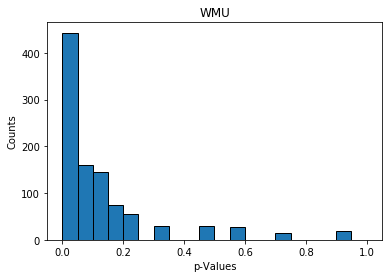

CPU times: user 426 ms, sys: 8.61 ms, total: 435 ms
Wall time: 433 ms


In [60]:
%%time
bins=np.linspace(0,1,21)
reps = 999
mean1, mean2 = 2, 0
s1, s2 = 2, 10
std1, std2 = 1.0, 1.0

p = np.zeros(reps)

for i in range(reps):
    x = np.random.normal(loc=mean1, scale=std1, size=s1)
    y = np.random.normal(loc=mean2, scale=std2, size=s2)
    #x=np.clip(x, 0, None)
    #y=np.clip(y, 0, None)
    p[i] = mannwhitneyu(x, y, alternative='two-sided')[1]
    
##### Plot figures of distribution p-Values
plt.figure()
ax = plt.gca()
ax.hist(p, bins=bins, ec="k")
ax.set_title("WMU")
ax.set_xlabel("p-Values")
ax.set_ylabel("Counts")
plt.show()

### Test Permanova

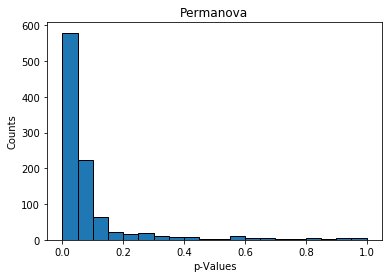

CPU times: user 8.26 s, sys: 3.33 ms, total: 8.27 s
Wall time: 8.27 s


In [59]:
%%time
reps = 999
bins=np.linspace(0,1,21)
mean1, mean2 = 2, 0
s1, s2 = 2, 10
std1, std2 = 1.0, 1.0

p = np.zeros(reps)

for i in range(reps):
    x = np.random.normal(loc=mean1, scale=std1, size=s1)
    y = np.random.normal(loc=mean2, scale=std2, size=s2)
    x=np.clip(x, 0, None)
    y=np.clip(y, 0, None)
    
    p[i] = anova_2group(x, y, reps=99)["p-value"]
    
##### Plot figures of distribution p-Values
plt.figure()
ax = plt.gca()
ax.hist(p, bins=bins, ec="k")
ax.set_title("Permanova")
ax.set_xlabel("p-Values")
ax.set_ylabel("Counts")
plt.show()

### t test

In [2]:
from scipy.stats import ttest_ind

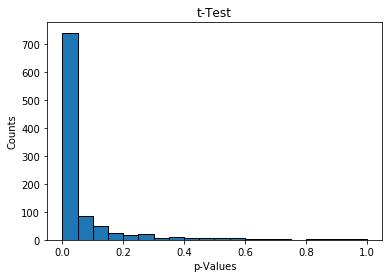

CPU times: user 492 ms, sys: 32.4 ms, total: 525 ms
Wall time: 491 ms


In [58]:
%%time
reps = 999
bins=np.linspace(0,1,21)
mean1, mean2 = 2, 0
s1, s2 = 2, 10
std1, std2 = 1.0, 1.0

p = np.zeros(reps)

for i in range(reps):
    x = np.random.normal(loc=mean1, scale=std1, size=s1)
    y = np.random.normal(loc=mean2, scale=std2, size=s2)
    x=np.clip(x, 0, None)
    y=np.clip(y, 0, None)
    
    p[i] = ttest_ind(x, y)[1]
    
##### Plot figures of distribution p-Values
plt.figure()
ax = plt.gca()
ax.hist(p, bins=bins, ec="k")
ax.set_title("t-Test")
ax.set_xlabel("p-Values")
ax.set_ylabel("Counts")
plt.show()